In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.feature_selection import mutual_info_regression

from scripts import *


In [11]:
undernourishment = pd.read_csv("../data/prevalence-of-undernourishment.csv") \
            .drop(['Code'], axis=1)\
            .rename(columns={'Entity': 'country', 'Prevalence of undernourishment (% of population)': 'undernourishment'}) \
            .query("Year == 2019").drop(['Year'], axis=1).reset_index(drop=True)

global_hunger_indx = pd.read_csv("../data/global-hunger-index.csv") \
    .drop(['Code', '411773-annotations'], axis=1)\
    .rename(columns={'Entity': 'country', 'Global Hunger Index (2021)': 'hunger_index'}) \
    .query("Year == 2021").drop(['Year'], axis=1).reset_index(drop=True)

# Feature Selection

## Multivariate regression based on MPI Index

Multidimensional Poverty Index is a product percentage of population in multidimensional poverty, $H$, and intensity of deprivation among the poor, $A$ (given as percentage of weighted deprivations):

$$MPI = HA$$

Load the data:

In [12]:
columns_to_drop = ['year',
                   'percentage_population_in_multidimensional_poverty',
                   'poverty_vulnerability',
                   'severe_poverty',
                   'percentage_population_in_multidimensional_destitution_poverty',
                   'proportion_of_mpi_ppor_who_are_destitute',
                   'deprevation_intensity']

data_raw = pd.read_csv('../data/country-data.csv')
mpi_data = pd.read_csv("../data/national_mpi.csv",
                       delimiter=";").drop(columns=columns_to_drop, axis=1)
mpi_area = pd.read_csv("../data/MPI.csv")
mpm_data = pd.read_csv("../data/mpm_worlbank.csv", delimiter=";")
mpm_data = mpm_data.replace(
    to_replace='-', value=0).drop("welfare_type", axis=1)
mpm_data.columns = [c.lower() for c in mpm_data.columns]

for column in mpi_data.columns:
    if column != 'country':
        mpi_data[column] = mpi_data[column].str.replace(',', '.').astype(float)

for column in mpm_data.columns:
    if column not in ('country', 'welfare_type'):
        mpm_data[column] = mpm_data[column].str.replace(',', '.').astype(float)

mpi_area.columns = [s.replace(' ', '_').lower() for s in mpi_area.columns]

# merge dataframes
raw_n_mpi = pd.merge(
    data_raw,
    mpi_data,
    on='country',
    how='inner'
)

raw_n_area = pd.merge(
    data_raw,
    mpi_area,
    on='country',
    how='inner',  # use 'left' to keep all rows from the left table
).drop(['iso'], axis=1)

raw_n_mpm = pd.merge(
    data_raw,
    mpm_data,
    on='country',
    how='inner'
)


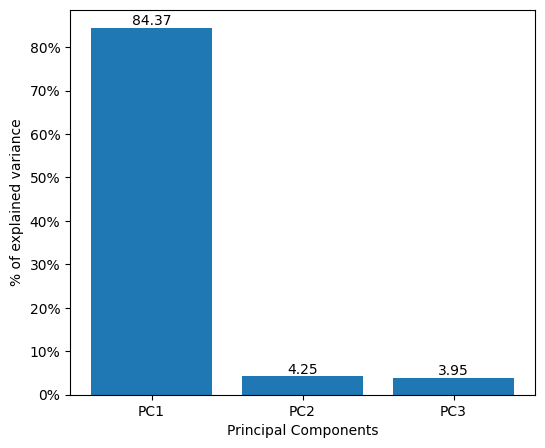

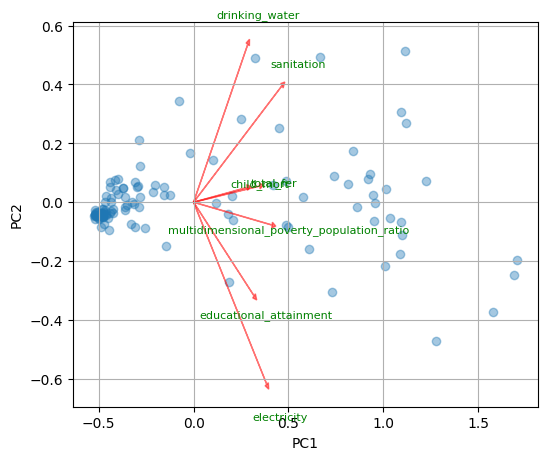

In [13]:
features = ['country',
            'sanitation',
            'electricity',
            'educational_attainment',
            'total_fer',
            'child_mort',
            'drinking_water',
            'multidimensional_poverty_population_ratio']

countries, pca_df, explained_variance = pre_process_data(raw_n_mpm[features].fillna(0),
                                                         scaler="minmax", pca_components=3, plot_scree_plot=True, pca=True, biplot=True)


In [18]:
clustered = apply_hierarchical_clustering(pca_df, 5)

clustered['name'] = countries
create_map_plot(clustered, "../out")

/var/folders/r8/9_x5mqbs79gbpktlgmt3lyb40000gn/T/ipykernel_13446/3059324750.py:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Text(0.5, 1.0, 'Spearman')

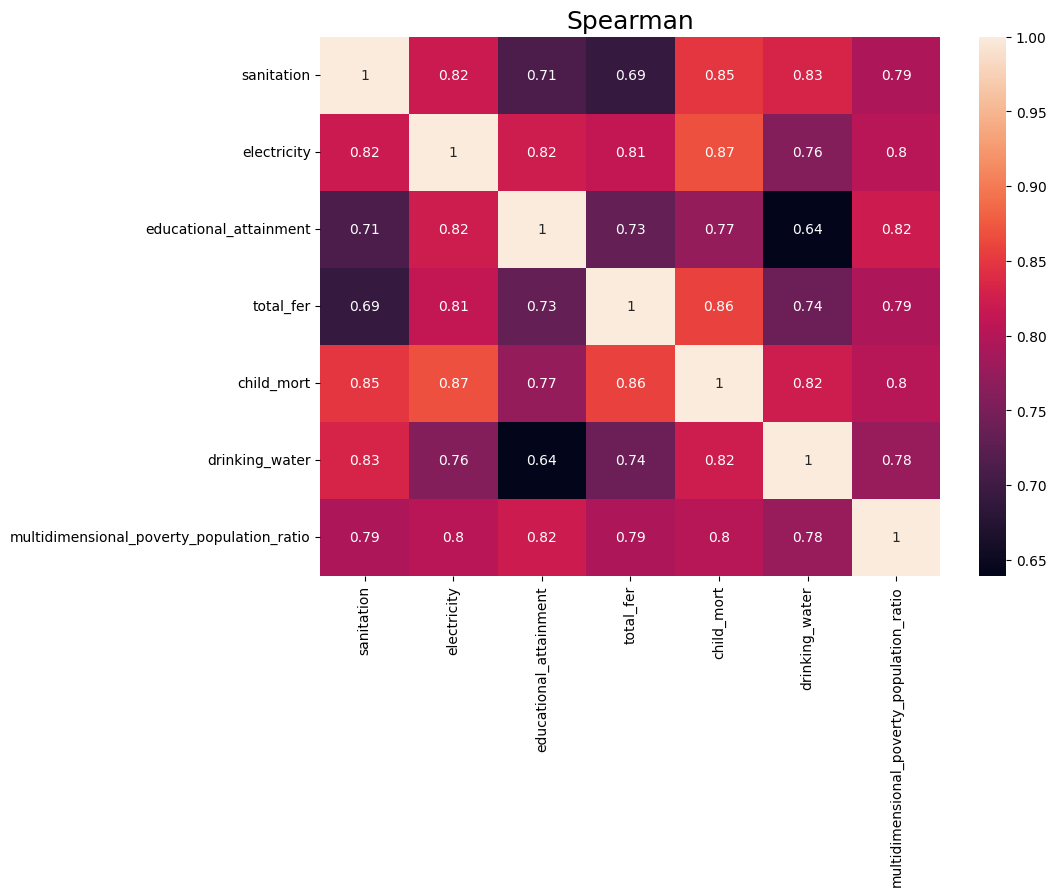

In [ ]:
method = 'spearman'

plt.figure(figsize=(10, 7))
sns.heatmap(raw_n_mpm[features].fillna(0).corr(
    method=method, min_periods=1), annot=True)
plt.title(method.title(), fontsize=18)


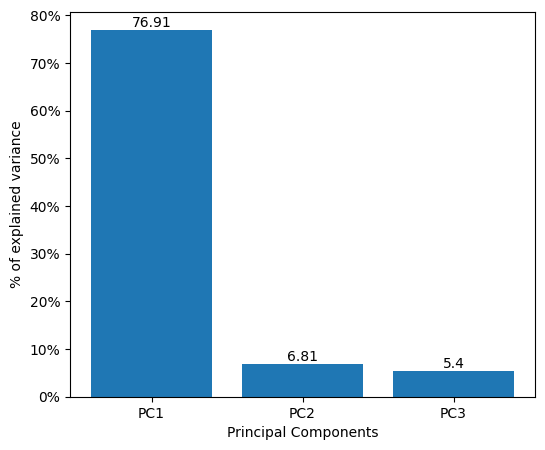

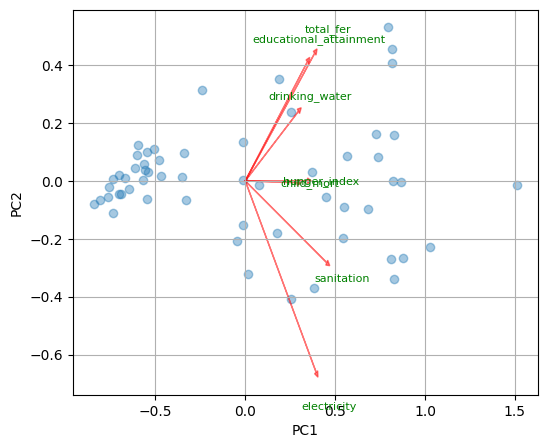

In [ ]:
all = pd.merge(
    raw_n_mpm,
    raw_n_mpi[['country','mpi']],
    on='country',
    how='inner'
    )

all = pd.merge(
    all,
    undernourishment,
    on='country',
    how='inner'
)

all = pd.merge(
    all,
    global_hunger_indx,
    on='country',
    how='inner'
)



features = ['country',
            'sanitation',
            'electricity',
            'educational_attainment',
            'total_fer',
            'child_mort',
            'drinking_water',
            #'mpi',
            #'multidimensional_poverty_population_ratio',
            #'undernourishment',
            'hunger_index'
            ]

countries, pca_df, explained_variance = pre_process_data(all[features].fillna(
    0), scaler="minmax", pca_components=3, plot_scree_plot=True, pca=True, biplot=True)


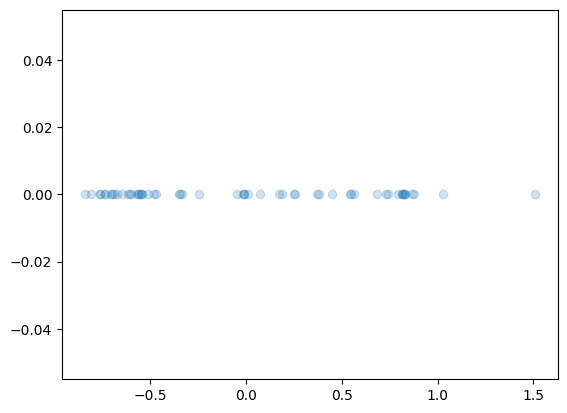

In [ ]:
plt.scatter(pca_df['PC1'], np.zeros(len(pca_df['PC1'])), alpha=0.2)


Consider MPI as dependent variable and see how much other features are correlated with it

                            OLS Regression Results                            
Dep. Variable:                    mpi   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     186.2
Date:                Mon, 02 Jan 2023   Prob (F-statistic):           1.97e-23
Time:                        19:25:31   Log-Likelihood:                 93.973
No. Observations:                  90   AIC:                            -183.9
Df Residuals:                      88   BIC:                            -178.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0317      0.015     -2.084      0.0

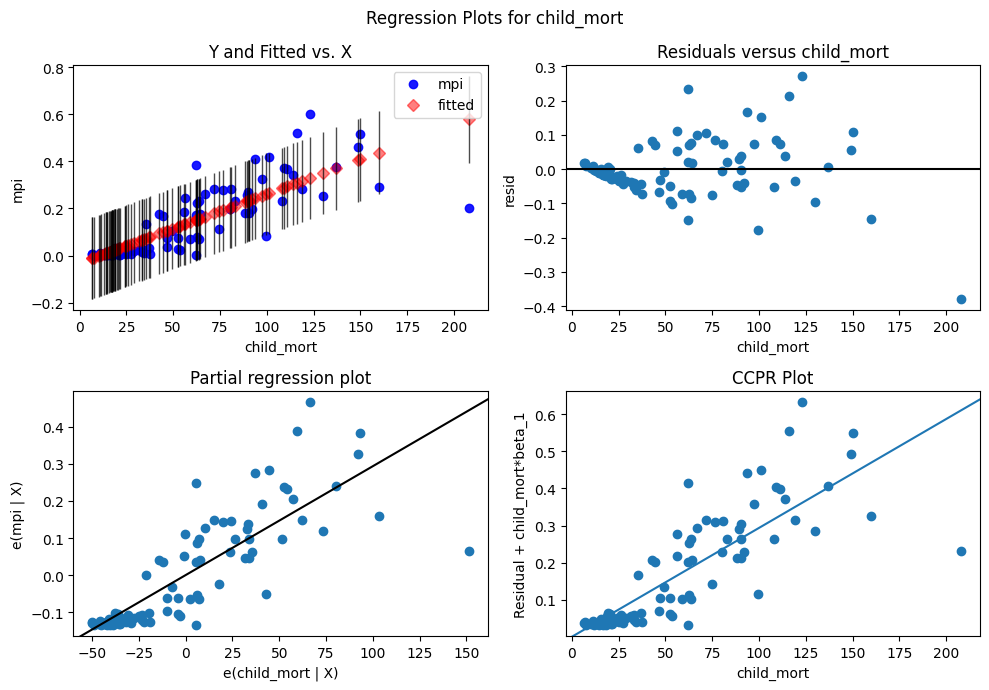

In [ ]:
reg = linear_model.LinearRegression()

# fit simple linear regression model
model = ols('mpi ~ child_mort', data=raw_n_mpi).fit()

# view model summary
print(model.summary())

# define figure size
fig = plt.figure(figsize=(10, 7))

# produce regression plots
fig = sm.graphics.plot_regress_exog(model, 'child_mort', fig=fig)


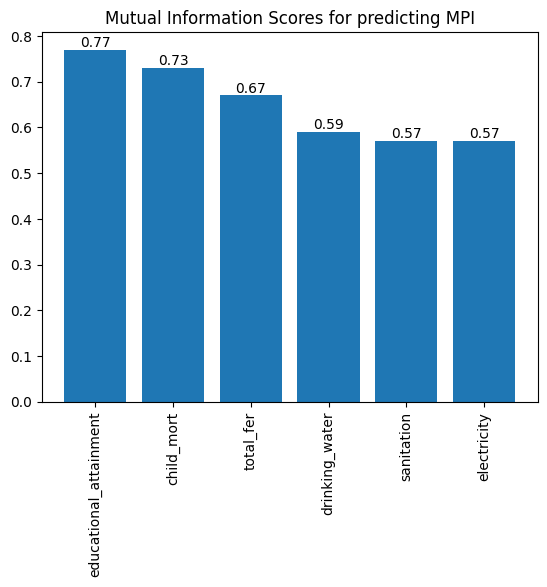

In [ ]:
features = ['country',
            'sanitation',
            'electricity',
            'educational_attainment',
            'total_fer',
            'child_mort',
            'drinking_water',
            'multidimensional_poverty_population_ratio',
            'mpi'
            ]
df = pd.merge(
    raw_n_mpm.fillna(0),
    raw_n_mpi[['country','mpi']],
    on='country',
    how='inner'
)[features]

clustered = apply_hierarchical_clustering(df.drop("country", axis=1), 3)


def make_mi_scores(X: pd.DataFrame, y, show: bool = False):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores",
                          index=X.columns).sort_values(ascending=False)

    if show:
        fig, ax = plt.subplots()
        bars = ax.bar(mi_scores.index, [round(x, 2) for x in mi_scores.values])
        ax.bar_label(bars)
        plt.xticks(rotation=90)
        plt.title("Mutual Information Scores for predicting MPI")
        plt.show()
    return mi_scores


mi_scores = make_mi_scores(df.drop(["country", 'multidimensional_poverty_population_ratio','mpi'], axis=1),
                           df['mpi'],
                           show=True)


/var/folders/r8/9_x5mqbs79gbpktlgmt3lyb40000gn/T/ipykernel_13446/3896686549.py:4: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Text(0.5, 1.0, 'Spearman')

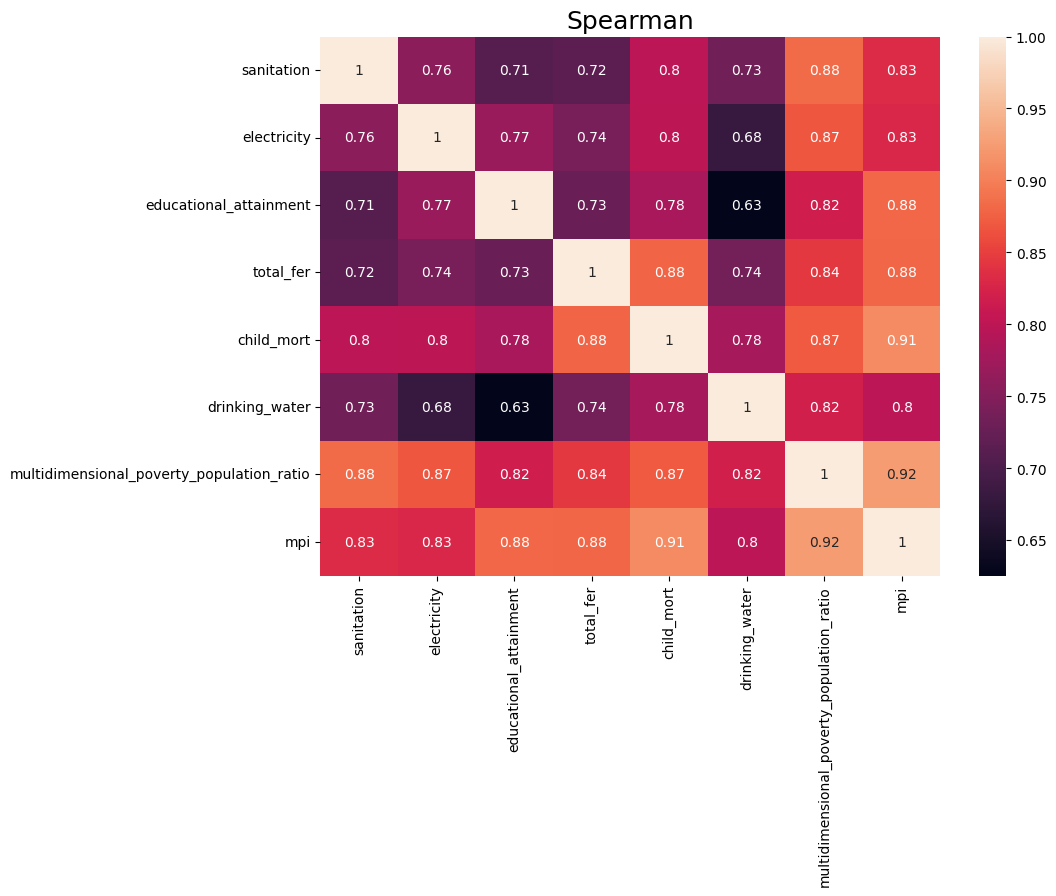

In [ ]:
method = 'spearman'

plt.figure(figsize=(10, 7))
sns.heatmap(df.fillna(0).corr(
    method=method, min_periods=1), annot=True)
plt.title(method.title(), fontsize=18)


Do the same for all other attributes in raw data that we have (exports, life_expectancy, etc). Then for further steps refer to:
https://www.kaggle.com/code/lauraviera/using-ml-to-allocate-funding-for-development-aid

# DBSCAN

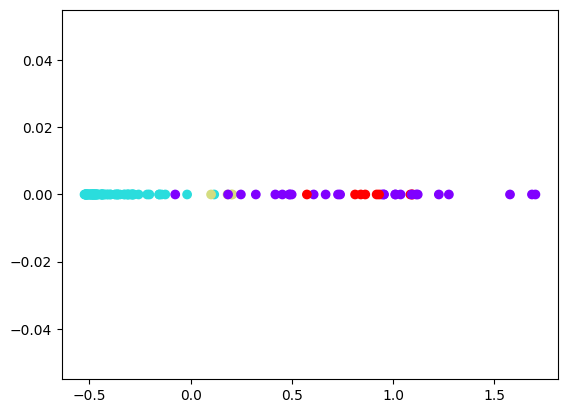

In [ ]:
features = ['country',
            'sanitation',
            'electricity',
            'educational_attainment',
            'total_fer',
            'child_mort',
            'drinking_water',
            'multidimensional_poverty_population_ratio']

countries, pca_df = pre_process_data(
    raw_n_mpm[features].fillna(0),
    scaler="minmax", pca_components=3, pca=False
    )


from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=3)
dbscan.fit_predict(pca_df)

pca = PCA(n_components=3)
pca_df = pd.DataFrame(pca.fit_transform(pca_df))

pca_df['cluster'] = dbscan.labels_

#scatter_plot_data(pca_df, [0, 1], hover_name=countries)
plt.scatter(pca_df[0], np.zeros(len(pca_df)), c=pca_df['cluster'], cmap='rainbow')